In [70]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import shutil

In [71]:
workdir_path=r"wos_extract"
outfile='wos_extract_complete.csv'
# with_header=True
# for root, dirs, files in os.walk(workdir_path):
#     for filename in files:
#         if filename.startswith("wosexport"):
#             path=os.path.join(root, filename)
#             print(path)
#             chunk = pd.read_excel(path)
#             chunk.to_csv(outfile, mode="a", index=False, header=with_header, sep="\t")
#             with_header = False

In [72]:
record_col="UT (Unique WOS ID)"

In [73]:
wos = pd.read_csv(outfile, sep="\t",low_memory=False)
metrix = pd.read_excel("sm_journal_classification.xlsx", sheet_name="Journal_Classification")


metrix = metrix.set_index([c for c in metrix.columns if "issn" not in c]).stack().reset_index()
metrix = metrix.rename(columns={'level_6':"issn_type", 0:"issn"})
metrix["issn"]=metrix["issn"].str.replace("-","").str.lower().str.strip()

wos["issn"] = wos["ISSN"].str.replace("-","").str.lower().str.strip()
wos["eissn"] = wos["eISSN"].str.replace("-","").str.lower().str.strip()
wos = wos.set_index([c for c in wos.columns if "issn" not in c]).stack().reset_index()
wos = wos.rename(columns={'level_72':"issn_var", 0:"issn"})

wos_merge = wos.merge(metrix, on="issn", how="left")
wos = wos_merge.sort_values(by="issn_var",ascending=False).drop_duplicates(subset=record_col)

In [74]:
pd.Series(wos.columns)

0       Publication Type
1                Authors
2           Book Authors
3           Book Editors
4     Book Group Authors
             ...        
76      SubField_English
77              2.00 SEQ
78          Source_title
79                 srcid
80             issn_type
Length: 81, dtype: object

In [75]:
wos["Researcher Ids"]

0        Salucci, Marco/S-8654-2016; Arrebola, Manuel/L...
9714                               Huang, Yu/AAY-5464-2020
9697     Kakavand, Mohammad Reza Azadi/X-9556-2019; Fen...
9699     Dong, Sheng/AAE-3619-2021; Soares, Carlos Gued...
9701     Han, Guoqi/T-7365-2019; Nan, Yang/HKD-9687-202...
                               ...                        
3066                         ; Liotta, Antonio/G-9532-2014
5097        , 卢帅/AAK-2185-2020; Popp, József/AFN-1250-2022
11369                                                  NaN
11368                            Rossiter, D G/D-3842-2009
11362                           Jin, Shuanggen/B-8094-2008
Name: Researcher Ids, Length: 9889, dtype: object

In [76]:
wos[(~wos["DOI"].isna())&(wos["DOI"].duplicated(False))]

Publication Type                                            Authors   
16979                J  Zhang, MS; Huang, J; Cao, Y; Xiong, CH; Mohamm...  \
1880                 J  Zhang, MS; Huang, J; Cao, Y; Xiong, CH; Mohamm...   

      Book Authors Book Editors Book Group Authors   
16979          NaN          NaN                NaN  \
1880           NaN          NaN                NaN   

                                       Author Full Names   
16979  Zhang, Mengshi; Huang, Jian; Cao, Yu; Xiong, C...  \
1880   Zhang, Mengshi; Huang, Jian; Cao, Yu; Xiong, C...   

      Book Author Full Names Group Authors   
16979                    NaN           NaN  \
1880                     NaN           NaN   

                                           Article Title   
16979  Echo State Network-Enhanced Super-Twisting Con...  \
1880   Echo State Network-Enhanced Super-Twisting Con...   

                                 Source Title  ... Web of Science Record   
16979  IEEE-ASME TRANSACTIONS ON MECHATRONICS  ...                     0  \
1880   IEEE-ASME TRANSACTIONS ON MECHATRONICS  ...                     0   

       issn_var      issn    Domain_English Field_English   
16979      issn  10834435  Applied Sciences   Engineering  \
1880       issn  10834435  Applied Sciences   Engineering   

                          SubField_English 2.00 SEQ   
16979  Industrial Engineering & Automation       27  \
1880   Industrial Engineering & Automation       27   

                                 Source_title    srcid issn_type  
16979  IEEE/ASME Transactions on Mechatronics  19113.0     issn1  
1880   IEEE/ASME Transactions on Mechatronics  19113.0     issn1  

[2 rows x 81 columns]

In [77]:
from flashgeotext.geotext import GeoText

geotext = GeoText()

def extract_location(input_text, key='countries'):
    anomalies = {"Malta":"Malta",
                 "Mongolia":"Mongolia",
                 "Quatar":"Qatar",
                 "Qatar":"Qatar",
                 "Ethiop":"Ethiopia",
                 "Nigeria":"Nigeria",
                 "BELAR":"Belarus",
                 "Venezuela":"Venezuela",
                 "Cyprus":"Cyprus",
                 "Ecuador":"Ecuador",
                 "U Arab":"United Arab Emirates",
                 "Syria":"Syria",
                 "Uganda":"Uganda",
                 "Yemen":"Yemen",
                 "Mali":"Mali",
                 "Senegal":"Senegal",
                 "Vatican":"Vatican",
                 "Uruguay":"Uruguay",
                 "Panama":"Panama",
                 "Fiji":"Fiji",
                 "Faroe":"Faroe Islands",
                 "Macedonia":"Macedonia",
                 'Mozambique':'Mozambique',
                 "Kuwait":"Kuwait",
                 "Libya":"Libya",
                 "Turkiy":"Turkey",
                 "Liberia":"Liberia",
                 "Namibia":"Namibia",
                 "Ivoire":"Ivory Coast",
                 "Guatemala":"Gutemala",
                 "Paraguay":"Paraguay",
                 "Honduras":"Honduras",
                 "Nicaragua":"Nicaragua",
                 "Trinidad":"Trinidad & Tobago",
                 "Liechtenstein":"Liechtenstein",
                 "Greenland":"Denmark"}

    extracted = geotext.extract(input_text=input_text)
    found = extracted[key].keys()
    if len(sorted(found))>0:
        return sorted(found)[0]
    elif key=='countries':
        for i  in ['Scotland','Wales','England']:
            if i in input_text:
                return 'United Kingdom'
        for j in anomalies.keys():
            if j in input_text:
                return anomalies.get(j)
    else:
        return None

with open('../eu_members.txt',"r") as f:
    eu_countries=f.readline().split(",")
    eu_countries=[i.strip() for i in eu_countries]

def country_type(country):
    if country in eu_countries:
        return "EU"
    elif country=="China":
        return "China"
    else:
        return "Other"


In [78]:
locations = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")
locations = locations[locations["Addresses"]!=""].copy()
locations["Address"] = locations["Addresses"].apply(lambda x:x.split("]")[-1])
locations["Authors_of_address"] = locations["Addresses"].apply(lambda x:x.split("]")[0])
locations["Country"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='countries'))
locations["City"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='cities'))
locations["Country_Type"] = locations["Country"].apply(lambda x: country_type(x))

In [119]:
univ_locations = locations[[record_col,"Address","Country","City","Country_Type"]].copy()
univ_locations["Institution"] = univ_locations["Address"].apply(lambda x: x.split(",")[0])
univ_locations.head()

UT (Unique WOS ID)                                            Address   
1  WOS:000209536100003   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...  \
2  WOS:000209536100003         Nat Hist Museum, London SW7 5BD, England;    
3  WOS:000209536100003              Pensoft Publishers, Sofia, Bulgaria;    
4  WOS:000209536100003    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;    
5  WOS:000209536100003   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...   

          Country       City Country_Type          Institution  
1           China  Hong Kong        China           BGI HK Ltd  
2  United Kingdom     London        Other      Nat Hist Museum  
3        Bulgaria      Sofia           EU   Pensoft Publishers  
4        Bulgaria      Sofia           EU      Nat Hist Museum  
5        Bulgaria       Rees           EU   Bulgarian Acad Sci

In [79]:
locations["Country"].value_counts()

Country
China            21063
United States     5913
Germany           4179
Italy             3195
France            2767
                 ...  
Faroe Islands        1
Honduras             1
Vatican              1
Macedonia            1
Jamaica              1
Name: count, Length: 137, dtype: int64

In [80]:
locations["Country_Type"].value_counts()

Country_Type
EU       21228
China    21063
Other    20404
Name: count, dtype: int64

In [81]:
author_locations = locations.groupby([record_col,"Country","Country_Type"])["Authors_of_address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_3")
author_locations["Author_name"] = author_locations["Authors_of_address"].str.strip()
author_locations = author_locations.drop(columns="Authors_of_address")
author_locations["author_str_id"] = author_locations["Author_name"].apply(lambda x:''.join(filter(str.isalnum, x.lower())))
author_locations

UT (Unique WOS ID)   Country Country_Type        Author_name   
0       WOS:000209536100003  Bulgaria           EU       Stoev, Pavel  \
1       WOS:000209536100003  Bulgaria           EU    Penev, Lyubomir   
2       WOS:000209536100003  Bulgaria           EU       Stoev, Pavel   
3       WOS:000209536100003  Bulgaria           EU    Penev, Lyubomir   
4       WOS:000209536100003     China        China  Edmunds, Scott C.   
...                     ...       ...          ...                ...   
173441  WOS:000947693400001     China        China        Peng, Sihua   
173442  WOS:000947693400001     China        China       Shen, Zhehan   
173443  WOS:000947693400001     China        China       Shen, Zhehan   
173444  WOS:000947693400001     China        China       Liu, Taigang   
173445  WOS:000947693400001     Spain           EU      Jiang, Linhua   

        author_str_id  
0          stoevpavel  
1       penevlyubomir  
2          stoevpavel  
3       penevlyubomir  
4       edmundsscottc  
...               ...  
173441      pengsihua  
173442     shenzhehan  
173443     shenzhehan  
173444     liutaigang  
173445    jianglinhua  

[173446 rows x 5 columns]

In [82]:
author_primary_region = author_locations.sort_values(by="Country_Type").drop_duplicates(subset=[record_col,"author_str_id"])
# author_primary_region

china=author_primary_region[author_primary_region["Country_Type"]=="China"][record_col].unique()
eu=author_primary_region[author_primary_region["Country_Type"]=="EU"][record_col].unique()

len(wos[((wos[record_col].isin(china))
         &
         (wos[record_col].isin(eu)))])

8925

In [83]:
len(wos)

9889

In [84]:
affiliations = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
# affiliations[affiliations["Affiliations"].str.lower().str.contains("chinese academy", na=False, regex=True)]["Affiliations"].value_counts()
affiliations["Affiliations"] = affiliations["Affiliations"].str.strip().str.upper().fillna("UNKNOWN")
affiliations = affiliations.drop_duplicates()

In [112]:
aff_ = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
loc_ = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")
print(len(aff_),len(loc_))

69747 64845


In [85]:
unique_inst = sorted([i.split(" ") for i in list(affiliations["Affiliations"].unique())], key=len)
# unique_inst = [[''.join(filter(str.isalnum, i)) for i in i_list] for i_list in unique_inst]
unique_inst = [[i.strip(",").strip("(").strip(")") for i in i_list] for i_list in unique_inst]
unique_inst

[['IDAHO'],
 ['ICREA'],
 ['CEA'],
 ['AGROPARISTECH'],
 ['LENOVO'],
 ['RIKEN'],
 ['MICROSOFT'],
 ['GLAXOSMITHKLINE'],
 ['UNICANCER'],
 ['INRIA'],
 ['CIBERESP'],
 ['SINOPEC'],
 ['PHILIPS'],
 ['CIRAD'],
 ['VITO'],
 ['IMEC'],
 ['ILLUMINA'],
 ['EURECOM'],
 ['BAIDU'],
 ['CIBEREHD'],
 ['UNKNOWN'],
 ['BAYCREST'],
 ['NOVARTIS'],
 ['ITER'],
 ['PELIN'],
 ['INRAE'],
 ['ASTRAZENECA'],
 ['ERICSSON'],
 ['IDIBAPS'],
 ['CGIAR'],
 ['UNILEVER'],
 ['GENENTECH'],
 ['TENCENT'],
 ['NICTA'],
 ['QUALCOMM'],
 ['INESC-ID'],
 ['CIBERES'],
 ['ALCATEL-LUCENT'],
 ['TEAGASC'],
 ['ABB'],
 ['HEWLETT-PACKARD'],
 ['AT&T'],
 ['RIGSHOSPITALET'],
 ['FORTISS'],
 ['AMAZON.COM'],
 ['BASF'],
 ['BOSCH'],
 ['CIBERSAM'],
 ['EURATOM'],
 ['UNINETTUNO'],
 ['E-ON'],
 ['DELPHI'],
 ['BIOGEN'],
 ['SAMSUNG'],
 ['INTERDIGITAL'],
 ['SYNGENTA'],
 ['CIBERONC'],
 ['IRTA'],
 ['MICA'],
 ['MEDTRONIC'],
 ['IFREMER'],
 ['DELTARES'],
 ['PROFIL'],
 ['SANOFI-AVENTIS'],
 ['REGENERON'],
 ['YUTONG'],
 ['CIBERBBN'],
 ['KAKAO'],
 ['DNV'],
 ['SCHLUMBERGER']

In [86]:
def institution_chunk_norris(text):
    for i in unique_inst:
        text_split=text.split(" ")
        text_split=[i.strip(",").strip("(").strip(")") for i in text_split]
        overlap = all(token in text_split for token in i)
        if overlap:
            return (" ".join(i))
    return "ERROR"

In [87]:
affiliations["Affiliations_merged"] = affiliations["Affiliations"].apply(lambda x: institution_chunk_norris(x))

In [88]:
affiliations["Affiliations"].value_counts()

Affiliations
CHINESE ACADEMY OF SCIENCES                            1188
UDICE-FRENCH RESEARCH UNIVERSITIES                      647
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS)     640
HELMHOLTZ ASSOCIATION                                   427
UNIVERSITY OF CHINESE ACADEMY OF SCIENCES, CAS          411
                                                       ... 
IMT NORD EUROPE                                           1
SANGMYUNG UNIVERSITY                                      1
INDIANA UNIVERSITY PURDUE UNIVERSITY FORT WAYNE           1
JAHANGIRNAGAR UNIVERSITY                                  1
SAINT JAMES'S UNIVERSITY HOSPITAL                         1
Name: count, Length: 4884, dtype: int64

In [89]:
affiliations["Affiliations_merged"].value_counts()

Affiliations_merged
CHINESE ACADEMY OF SCIENCES                          1725
NANJING UNIVERSITY                                    737
SHANGHAI UNIVERSITY                                   667
UDICE-FRENCH RESEARCH UNIVERSITIES                    647
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS     640
                                                     ... 
ULVAC INC.                                              1
NATIONAL METROLOGY INSTITUTE OF JAPAN                   1
SHEFFIELD HALLAM UNIVERSITY                             1
GLOBAL INSTITUTE FOR WATER SECURITY                     1
SAINT JAMES'S UNIVERSITY HOSPITAL                       1
Name: count, Length: 4241, dtype: int64

In [90]:
affiliations[affiliations["Affiliations_merged"]=="ERROR"]

Empty DataFrame
Columns: [UT (Unique WOS ID), Affiliations, Affiliations_merged]
Index: []

In [123]:
from nltk.metrics import edit_distance
#results = df.apply(lambda x: edit_distance(x["column1"], x["column2"]), axis=1)

In [125]:
affiliations = affiliations.merge(univ_locations, on=record_col)

UT (Unique WOS ID)                   Affiliations   
0  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON  \
1  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
2  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
3  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
4  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   

             Affiliations_merged   
0  NATURAL HISTORY MUSEUM LONDON  \
1  NATURAL HISTORY MUSEUM LONDON   
2  NATURAL HISTORY MUSEUM LONDON   
3  NATURAL HISTORY MUSEUM LONDON   
4  NATURAL HISTORY MUSEUM LONDON   

                                             Address         Country   
0   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...           China  \
1         Nat Hist Museum, London SW7 5BD, England;   United Kingdom   
2              Pensoft Publishers, Sofia, Bulgaria;         Bulgaria   
3    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;         Bulgaria   
4   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...        Bulgaria   

        City Country_Type          Institution  
0  Hong Kong        China           BGI HK Ltd  
1     London        Other      Nat Hist Museum  
2      Sofia           EU   Pensoft Publishers  
3      Sofia           EU      Nat Hist Museum  
4       Rees           EU   Bulgarian Acad Sci

In [128]:
affiliations["Affiliations"] = affiliations["Affiliations"].str.upper().str.strip()
affiliations["Institution"] = affiliations["Institution"].str.upper().str.strip()

affiliations["levehnstein"] = affiliations.apply(
    lambda x: edit_distance(x["Affiliations"], x["Institution"]), axis=1)
affiliations.head()

UT (Unique WOS ID)                   Affiliations   
0  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON  \
1  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
2  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
3  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
4  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   

             Affiliations_merged   
0  NATURAL HISTORY MUSEUM LONDON  \
1  NATURAL HISTORY MUSEUM LONDON   
2  NATURAL HISTORY MUSEUM LONDON   
3  NATURAL HISTORY MUSEUM LONDON   
4  NATURAL HISTORY MUSEUM LONDON   

                                             Address         Country   
0   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...           China  \
1         Nat Hist Museum, London SW7 5BD, England;   United Kingdom   
2              Pensoft Publishers, Sofia, Bulgaria;         Bulgaria   
3    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;         Bulgaria   
4   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...        Bulgaria   

        City Country_Type         Institution  levehnstein  
0  Hong Kong        China          BGI HK LTD           24  
1     London        Other     NAT HIST MUSEUM           14  
2      Sofia           EU  PENSOFT PUBLISHERS           25  
3      Sofia           EU     NAT HIST MUSEUM           14  
4       Rees           EU  BULGARIAN ACAD SCI           25

In [133]:
affiliations = affiliations.sort_values(by=[record_col,"Affiliations","levehnstein"], ascending=[False,False,True])
affiliations_merge = affiliations.drop_duplicates(subset=[record_col,"Affiliations"])
affiliations_merge.head(10)

UT (Unique WOS ID)                               Affiliations   
2430154  WOS:000947693400001        UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132  WOS:000947693400001                    SHANGHAITECH UNIVERSITY   
2430139  WOS:000947693400001                  SHANGHAI OCEAN UNIVERSITY   
2430146  WOS:000947693400001              SHANGHAI JIAO TONG UNIVERSITY   
2430125  WOS:000947693400001                          HUZHOU UNIVERSITY   
2430113  WOS:000946746700001  SUZHOU UNIVERSITY OF SCIENCE & TECHNOLOGY   
2430118  WOS:000946746700001            POLYTECHNIC UNIVERSITY OF MILAN   
2430123  WOS:000946746700001           HONG KONG POLYTECHNIC UNIVERSITY   
2430111  WOS:000945297300001                     UNIVERSITY OF PANNONIA   
2430107  WOS:000945297300001          SHENYANG UNIVERSITY OF TECHNOLOGY   

                               Affiliations_merged   
2430154        UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132                    SHANGHAITECH UNIVERSITY   
2430139                        SHANGHAI UNIVERSITY   
2430146                        SHANGHAI UNIVERSITY   
2430125                          HUZHOU UNIVERSITY   
2430113  SUZHOU UNIVERSITY OF SCIENCE & TECHNOLOGY   
2430118                        UNIVERSITY OF MILAN   
2430123           HONG KONG POLYTECHNIC UNIVERSITY   
2430111                     UNIVERSITY OF PANNONIA   
2430107                        SHENYANG UNIVERSITY   

                                                   Address  Country   
2430154   Univ Politecn Valencia, European Inst Innovat...    Spain  \
2430132   ShanghaiTech Univ, Shanghai Inst Adv Immunoch...    China   
2430139   Shanghai Ocean Univ, Coll Fisheries & Life Sc...    China   
2430146   Shanghai Jiao Tong Univ, Ruijin Hosp, Sch Med...    China   
2430125   Huzhou Univ, Sch Informat Engn, Huzhou 313000...    China   
2430113   Suzhou Univ Sci & Technol, Sch Elect & Inform...    China   
2430118     Politecn Milan, Dept Mech Engn, Milan, Italy;     Italy   
2430123   Hong Kong Polytech Univ, Dept Comp, Hong Kong...    China   
2430111   Univ Pannonia, Dept Elect Engn & Informat Sys...  Hungary   
2430107   Shenyang Univ Technol, Sch Elect Engn, Dept B...    China   

              City Country_Type                Institution  levehnstein  
2430154   Valencia           EU     UNIV POLITECN VALENCIA           13  
2430132   Shanghai        China          SHANGHAITECH UNIV            6  
2430139   Shanghai        China        SHANGHAI OCEAN UNIV            6  
2430146       Meda        China    SHANGHAI JIAO TONG UNIV            6  
2430125     Huzhou        China                HUZHOU UNIV            6  
2430113     Suzhou        China  SUZHOU UNIV SCI & TECHNOL           16  
2430118     Milano           EU             POLITECN MILAN           18  
2430123  Hong Kong        China    HONG KONG POLYTECH UNIV            9  
2430111   Veszprém           EU              UNIV PANNONIA            9  
2430107   Shenyang        China      SHENYANG UNIV TECHNOL           12

In [91]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"].value_counts()

WoS Categories
 Engineering, Electrical & Electronic         1703
Computer Science, Artificial Intelligence     1366
Computer Science, Information Systems          973
 Telecommunications                            834
 Imaging Science & Photographic Technology     762
                                              ... 
 Crystallography                                 1
Mining & Mineral Processing                      1
 Art                                             1
Archaeology                                      1
Physics, Mathematical                            1
Name: count, Length: 379, dtype: int64

In [92]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  3740
Computer Science                             3466
Telecommunications                            888
Imaging Science & Photographic Technology     779
Remote Sensing                                716
                                             ... 
Otorhinolaryngology                             1
Medical Ethics                                  1
Anesthesiology                                  1
Biomedical Social Sciences                      1
History & Philosophy of Science                 1
Name: count, Length: 141, dtype: int64

In [93]:
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  3740
Computer Science                             3466
Telecommunications                            888
Imaging Science & Photographic Technology     779
Remote Sensing                                716
                                             ... 
Otorhinolaryngology                             1
Medical Ethics                                  1
Anesthesiology                                  1
Biomedical Social Sciences                      1
History & Philosophy of Science                 1
Name: count, Length: 141, dtype: int64

In [94]:
[c for c in wos.columns if "_English" in c]

['Domain_English', 'Field_English', 'SubField_English']

In [95]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import math

In [96]:
wos = wos[((wos["Publication Year"]<2023) & (~wos['Domain_English'].isna()))]

metrix_levels = [c for c in wos.columns if "_English" in c]
for m in metrix_levels:
    wos[m] = wos[m].replace({"article-level classification":"Miscellaneous"})


In [97]:
wos

Publication Type                                            Authors   
0                    J           Salucci, M; Arrebola, M; Shan, T; Li, MK  \
9714                 J                     Huang, Y; Fu, ZT; Franzke, CLE   
9697                 J  Feng, DC; Cetiner, B; Kakavand, MRA; Taciroglu, E   
9699                 J           Zhao, YL; Dong, S; Jiang, FY; Soares, CG   
9701                 J  Li, XH; Yang, DK; Yang, JS; Zheng, G; Han, GQ;...   
...                ...                                                ...   
3066                 J  He, Q; Zha, C; Song, W; Hao, ZZ; Du, YL; Liott...   
5097                 J                        Hasan, MM; Popp, J; Olah, J   
11369                J                 Li, Y; Cheng, G; Pang, YS; Kuai, M   
11368                J  Zeng, R; Rossiter, DG; Zhang, JP; Cai, K; Gao,...   
11362                J  Jia, Y; Jin, SG; Savi, P; Gao, Y; Tang, J; Che...   

      Book Authors Book Editors Book Group Authors   
0              NaN          NaN                NaN  \
9714           NaN          NaN                NaN   
9697           NaN          NaN                NaN   
9699           NaN          NaN                NaN   
9701           NaN          NaN                NaN   
...            ...          ...                ...   
3066           NaN          NaN                NaN   
5097           NaN          NaN                NaN   
11369          NaN          NaN                NaN   
11368          NaN          NaN                NaN   
11362          NaN          NaN                NaN   

                                       Author Full Names   
0      Salucci, Marco; Arrebola, Manuel; Shan, Tao; L...  \
9714     Huang, Yu; Fu, Zuntao; Franzke, Christian L. E.   
9697   Feng, De-Cheng; Cetiner, Barbaros; Kakavand, M...   
9699   Zhao, Yuliang; Dong, Sheng; Jiang, Fengyuan; G...   
9701   Li, Xiaohui; Yang, Dongkai; Yang, Jingsong; Zh...   
...                                                  ...   
3066   He, Qi; Zha, Cheng; Song, Wei; Hao, Zengzhou; ...   
5097      Hasan, Md Morshadul; Popp, Jozsef; Olah, Judit   
11369  Li, Yong; Cheng, Gang; Pang, Yusong; Kuai, Moshen   
11368  Zeng, Rong; Rossiter, David G.; Zhang, Jiapeng...   
11362  Jia, Yan; Jin, Shuanggen; Savi, Patrizia; Gao,...   

      Book Author Full Names Group Authors   
0                        NaN           NaN  \
9714                     NaN           NaN   
9697                     NaN           NaN   
9699                     NaN           NaN   
9701                     NaN           NaN   
...                      ...           ...   
3066                     NaN           NaN   
5097                     NaN           NaN   
11369                    NaN           NaN   
11368                    NaN           NaN   
11362                    NaN           NaN   

                                           Article Title   
0      Artificial Intelligence: New Frontiers in Real...  \
9714   Detecting causality from time series in a mach...   
9697   Data-Driven Approach to Predict the Plastic Hi...   
9699   System Reliability Analysis of an Offshore Jac...   
9701   Analysis of coastal wind speed retrieval from ...   
...                                                  ...   
3066   Improved Particle Swarm Optimization for Sea S...   
5097   Current landscape and influence of big data on...   
11369  Planetary Gear Fault Diagnosis via Feature Ima...   
11368  How Well Can Reflectance Spectroscopy Allocate...   
11362  GNSS-R Soil Moisture Retrieval Based on a XGbo...   

                                        Source Title  ...   
0      IEEE TRANSACTIONS ON ANTENNAS AND PROPAGATION  ...  \
9714                                           CHAOS  ...   
9697               JOURNAL OF STRUCTURAL ENGINEERING  ...   
9699            JOURNAL OF OCEAN UNIVERSITY OF CHINA  ...   
9701                   REMOTE SENSING OF ENVIRONMENT  ...   
...                                              ...  ...   
3066      

In [98]:
metrix_levels

['Domain_English', 'Field_English', 'SubField_English']

In [134]:
outdir="wos_processed_data"
os.makedirs(outdir, exist_ok=True)

wos.to_excel(f"{outdir}/wos_processed.xlsx", index=False)

locations.drop(columns="Addresses").to_excel(f"{outdir}/wos_addresses.xlsx", index=False)

affiliations_merge.to_excel(f"{outdir}/wos_affiliations.xlsx", index=False)

author_locations.to_excel(f"{outdir}/wos_author_locations.xlsx", index=False)

univ_locations.to_excel(f"{outdir}/wos_univ_locations.xlsx", index=False)

# Domain

In [31]:
group = 'Domain_English'
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)
data

Domain_English  UT (Unique WOS ID)
0            Applied Sciences                5379
5            Natural Sciences                1649
3             Health Sciences                1106
2  Economic & Social Sciences                 289
4               Miscellaneous                 156
1           Arts & Humanities                  13

<Axes: xlabel='UT (Unique WOS ID)', ylabel='Domain_English'>

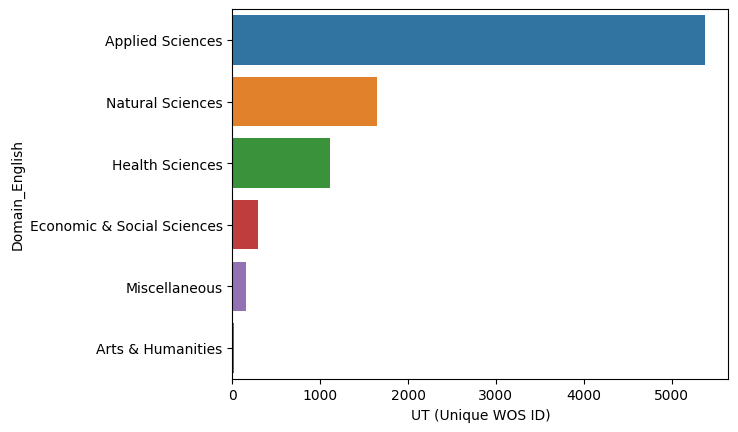

In [32]:
sns.barplot(data, x=record_col, y=group)

In [33]:
# group = ['Publication Year','Domain_English']
# data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
# data

In [34]:
group = ['Publication Year','Domain_English']
data = wos.groupby(group)[record_col].nunique().unstack(fill_value=0).stack().reset_index().rename(columns={0:record_col}).sort_values(ascending=False, by=group+[record_col])
data

Publication Year              Domain_English  UT (Unique WOS ID)
65            2022.0            Natural Sciences                 524
64            2022.0               Miscellaneous                  41
63            2022.0             Health Sciences                 368
62            2022.0  Economic & Social Sciences                 106
61            2022.0           Arts & Humanities                   4
..               ...                         ...                 ...
4             2012.0               Miscellaneous                   3
3             2012.0             Health Sciences                   2
2             2012.0  Economic & Social Sciences                   0
1             2012.0           Arts & Humanities                   0
0             2012.0            Applied Sciences                  21

[66 rows x 3 columns]

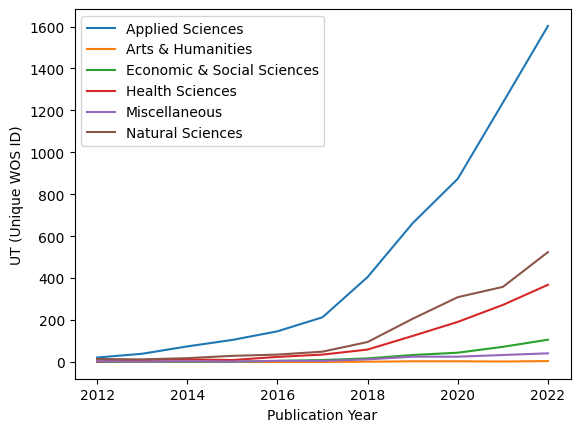

In [35]:
g=sns.lineplot(data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
g.set(xticks=list(range(2012,2022+1,2)))
g.legend(title=None)

# Field

In [65]:
group = ['Publication Year',"Domain_English",'Field_English']
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data

Publication Year    Domain_English   
176            2022.0  Natural Sciences  \
175            2022.0  Natural Sciences   
174            2022.0  Natural Sciences   
173            2022.0  Natural Sciences   
172            2022.0  Natural Sciences   
..                ...               ...   
4              2012.0     Miscellaneous   
3              2012.0   Health Sciences   
2              2012.0  Applied Sciences   
1              2012.0  Applied Sciences   
0              2012.0  Applied Sciences   

                                Field_English  UT (Unique WOS ID)  
176                       Physics & Astronomy                 205  
175                  Mathematics & Statistics                  61  
174            Earth & Environmental Sciences                 134  
173                                 Chemistry                  81  
172                                   Biology                  43  
..                                        ...                 ...  
4                               Miscellaneous                   3  
3                           Clinical Medicine                   2  
2    Information & Communication Technologies                  14  
1                                 Engineering                   5  
0           Agriculture, Fisheries & Forestry                   2  

[177 rows x 4 columns]

In [37]:
# g = sns.FacetGrid(data, col="Domain_English", col_wrap=3, height=5)
# g.map_dataframe(sns.lineplot,x=group[0],y=record_col,hue=group[-1])
# g.set_titles(col_template="{col_name}")
# g.set(xticks=list(range(2012,2022+1,2)))
# # g.add_legend()

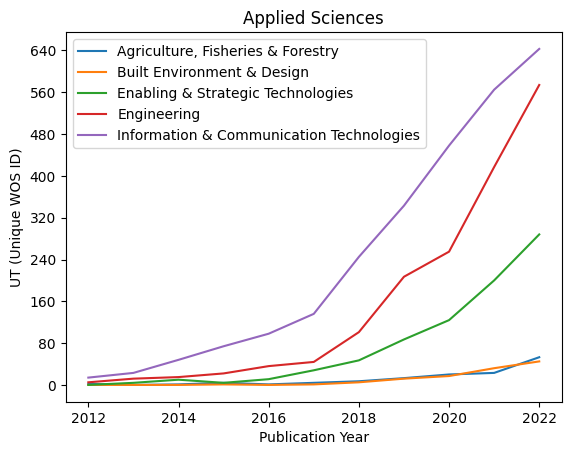

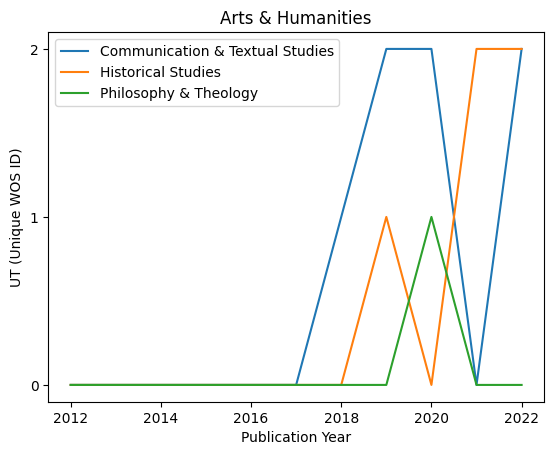

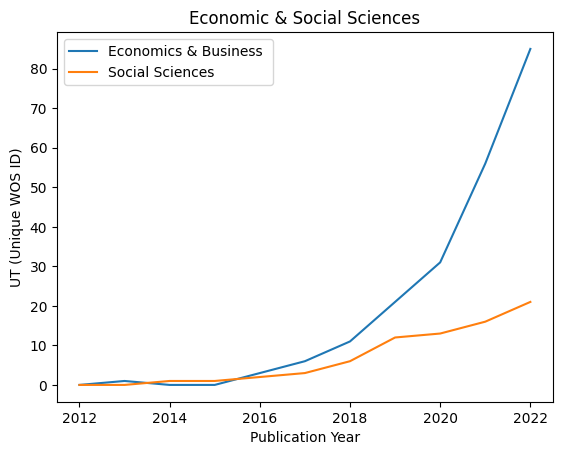

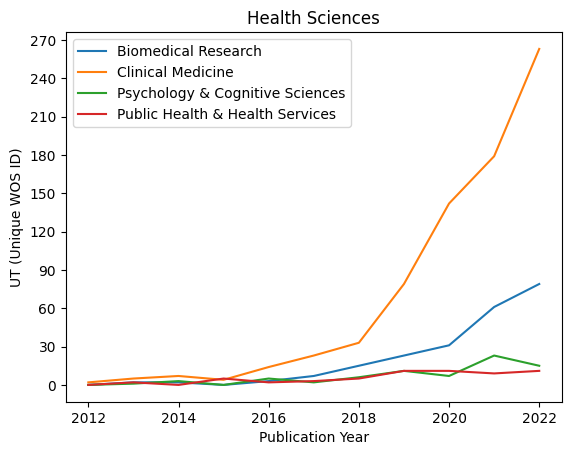

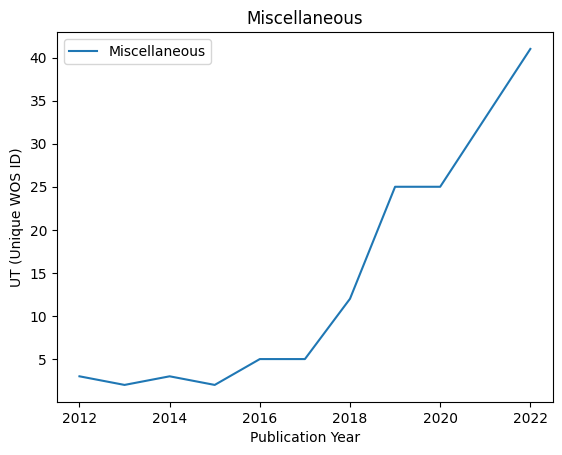

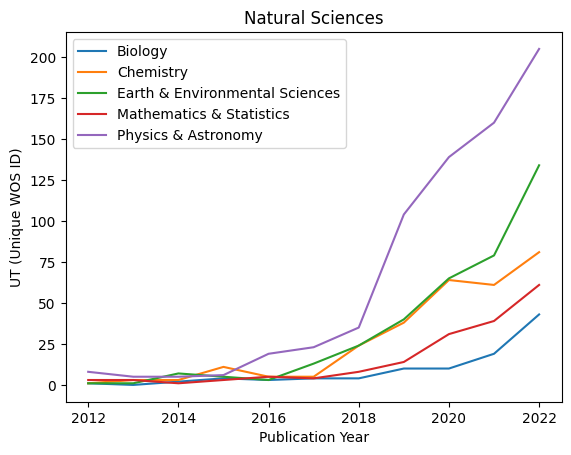

In [66]:
import matplotlib.pyplot as plt
for cat in sorted(data[group[-2]].unique()):
    sub_data = data[data[group[-2]]==cat]
    sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
                                 ,group[-1],fill_value=0)
    g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
    g.set(xticks=list(range(2012,2022+1,2)))
    g.legend(title=None)
    g.set_title(cat)
    g.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# SubField

In [68]:
group = ['Publication Year',"Domain_English",'Field_English',"SubField_English"]
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data

Publication Year    Domain_English   
774            2022.0  Natural Sciences  \
773            2022.0  Natural Sciences   
772            2022.0  Natural Sciences   
771            2022.0  Natural Sciences   
770            2022.0  Natural Sciences   
..                ...               ...   
4              2012.0  Applied Sciences   
3              2012.0  Applied Sciences   
2              2012.0  Applied Sciences   
1              2012.0  Applied Sciences   
0              2012.0  Applied Sciences   

                                Field_English   
774                       Physics & Astronomy  \
773                       Physics & Astronomy   
772                       Physics & Astronomy   
771                       Physics & Astronomy   
770                       Physics & Astronomy   
..                                        ...   
4    Information & Communication Technologies   
3                                 Engineering   
2                                 Engineering   
1                                 Engineering   
0           Agriculture, Fisheries & Forestry   

                               SubField_English  UT (Unique WOS ID)  
774                                      Optics                  56  
773                  Nuclear & Particle Physics                  28  
772                        Mathematical Physics                   2  
771                             General Physics                  14  
770                            Fluids & Plasmas                  21  
..                                          ...                 ...  
4    Artificial Intelligence & Image Processing                  10  
3           Mechanical Engineering & Transports                   1  
2           Industrial Engineering & Automation                   3  
1            Geological & Geomatics Engineering                   1  
0                                  Food Science                   2  

[775 rows x 5 columns]

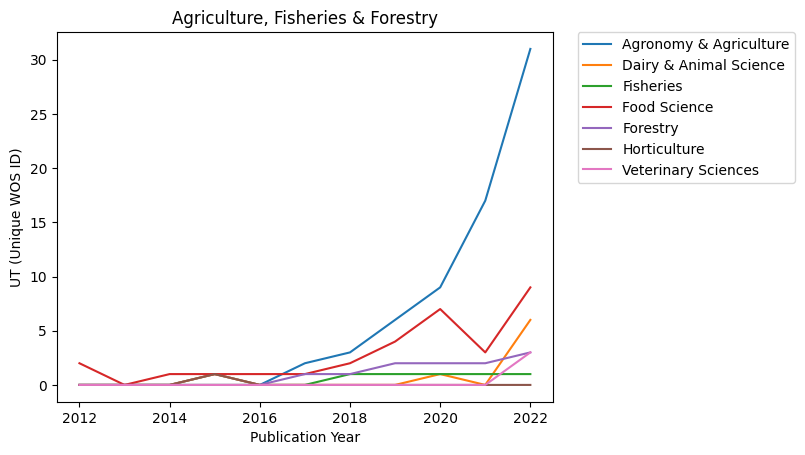

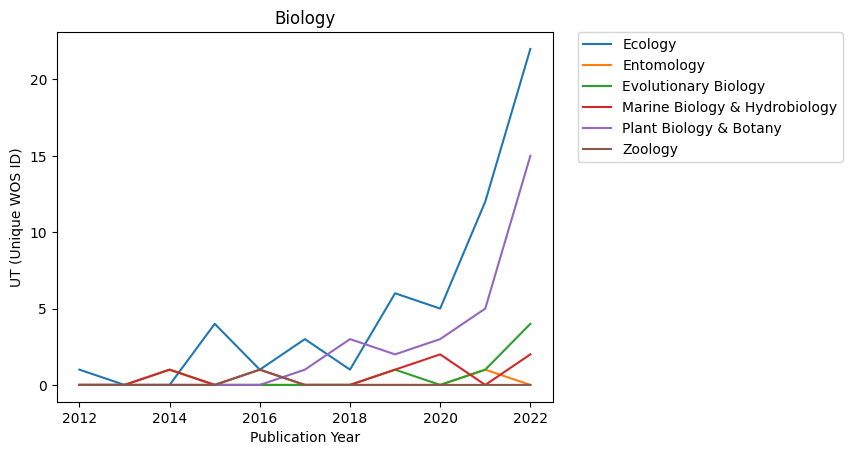

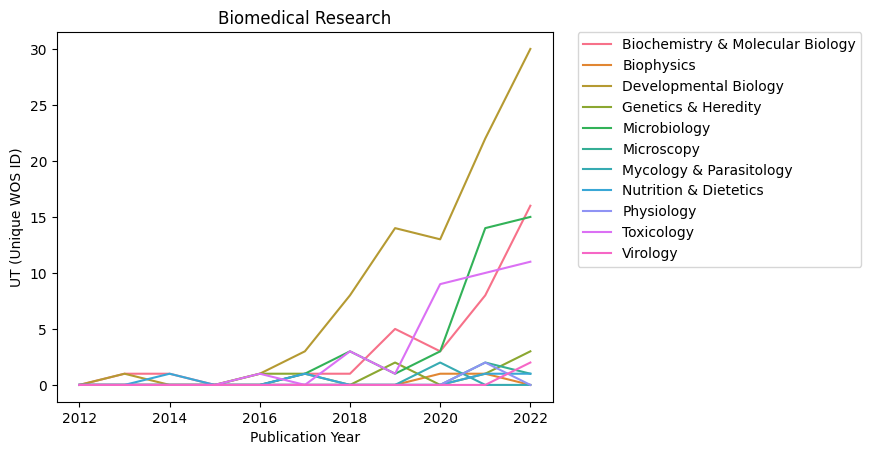

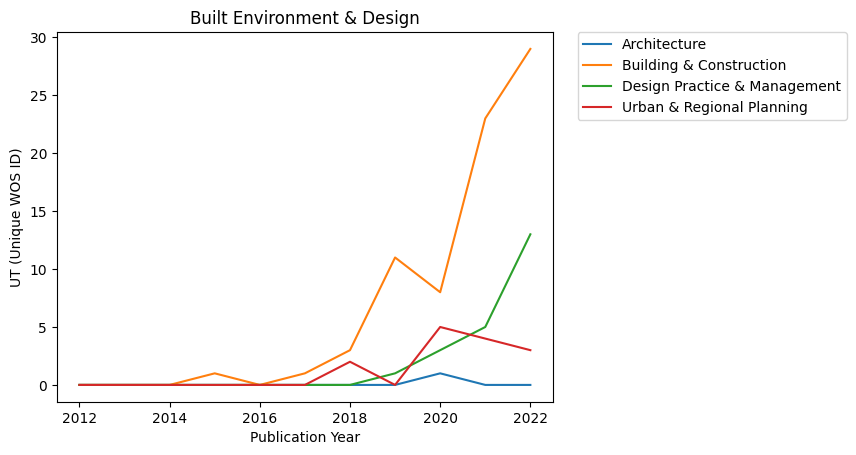

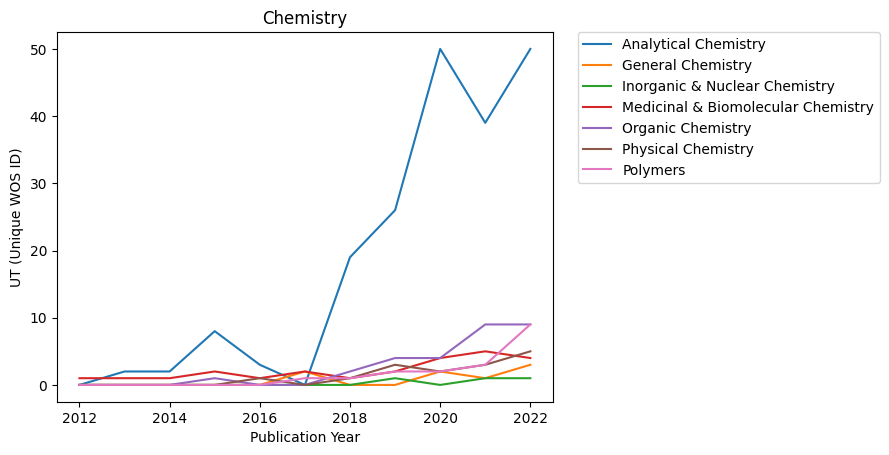

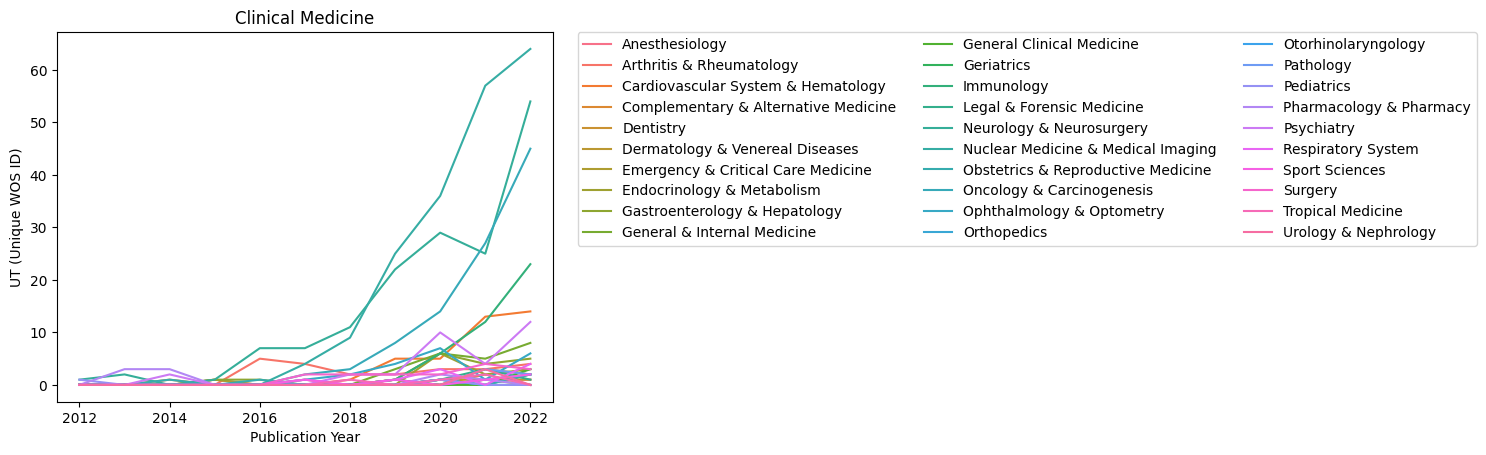

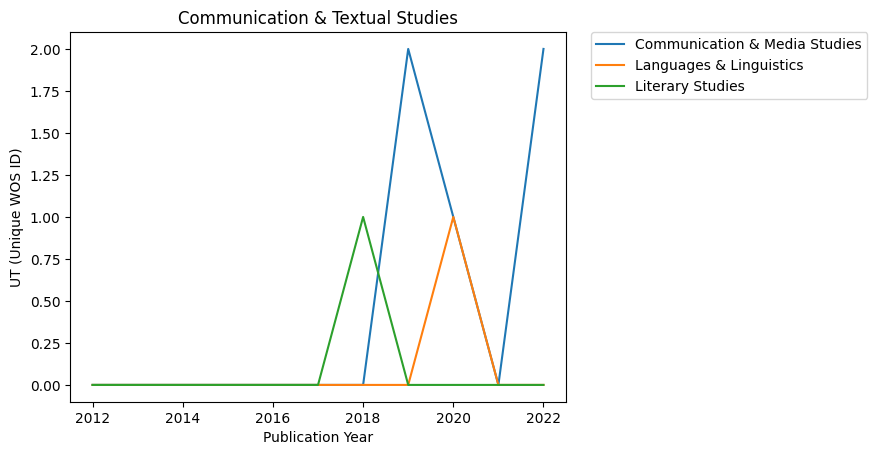

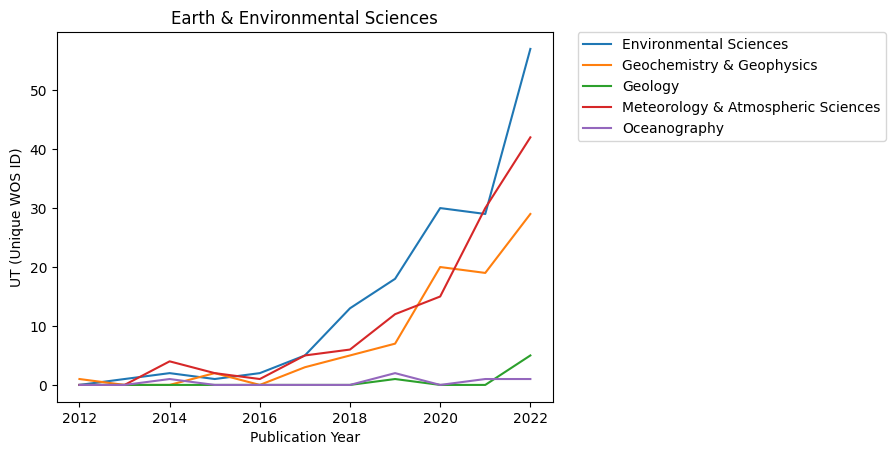

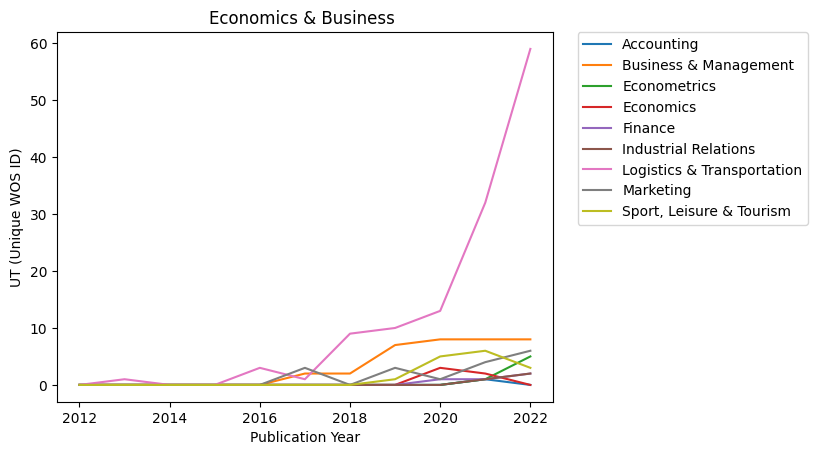

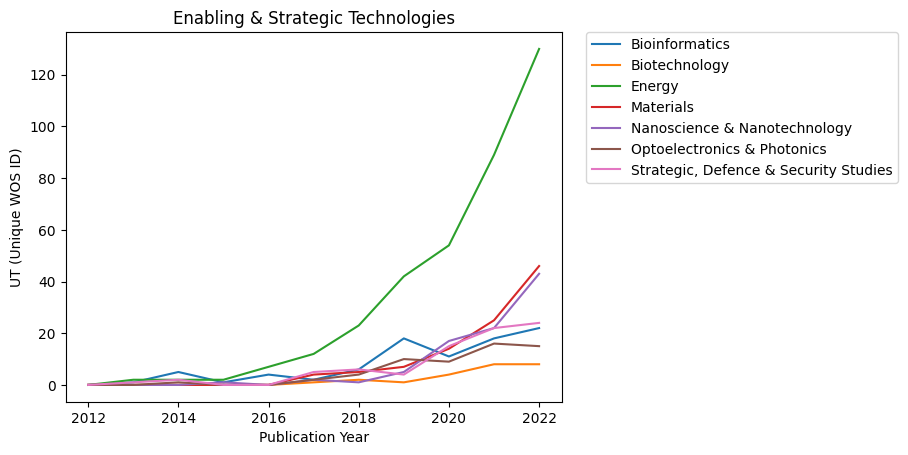

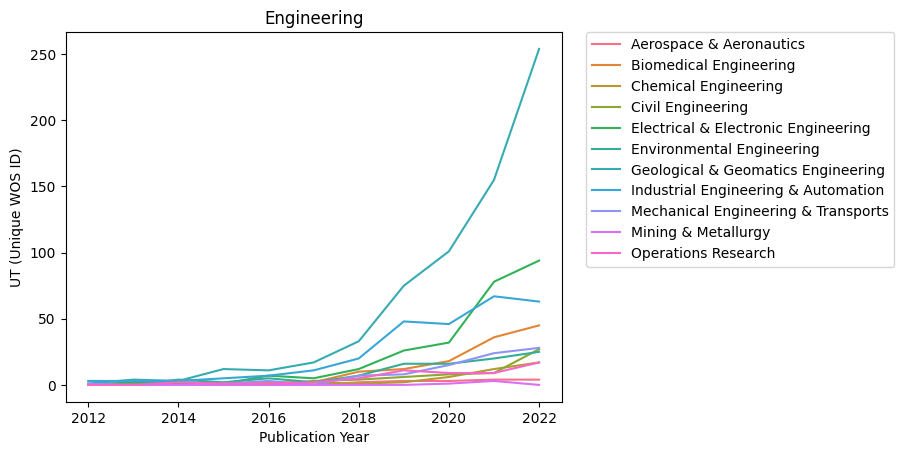

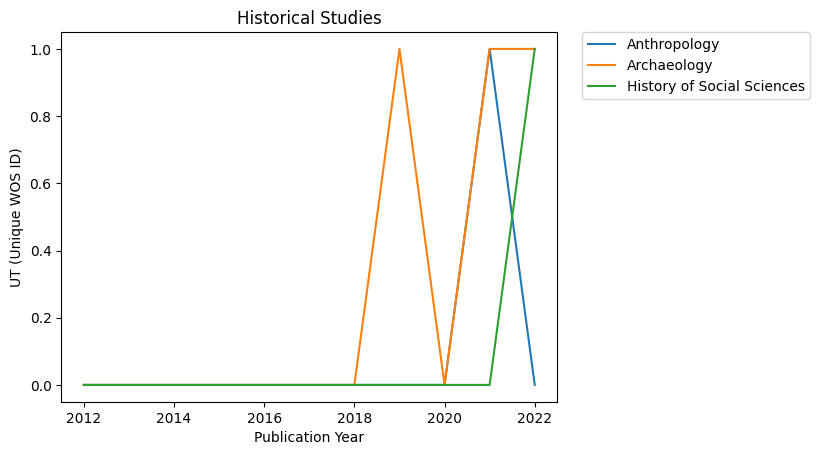

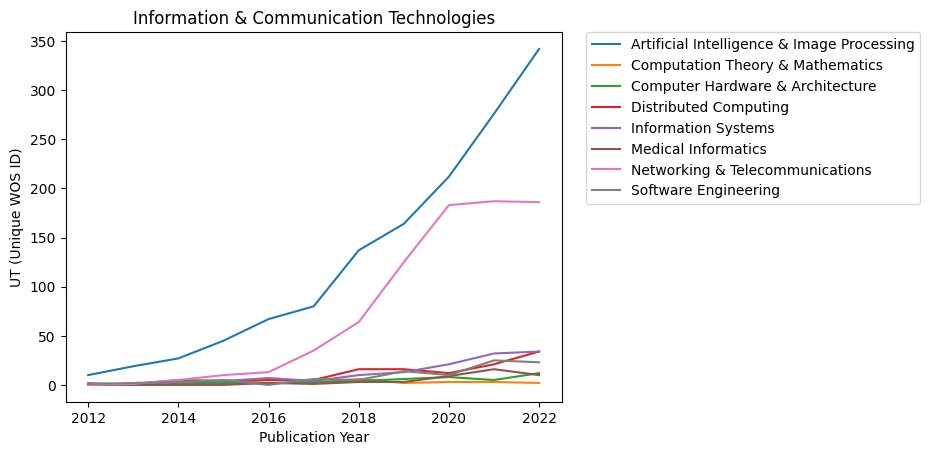

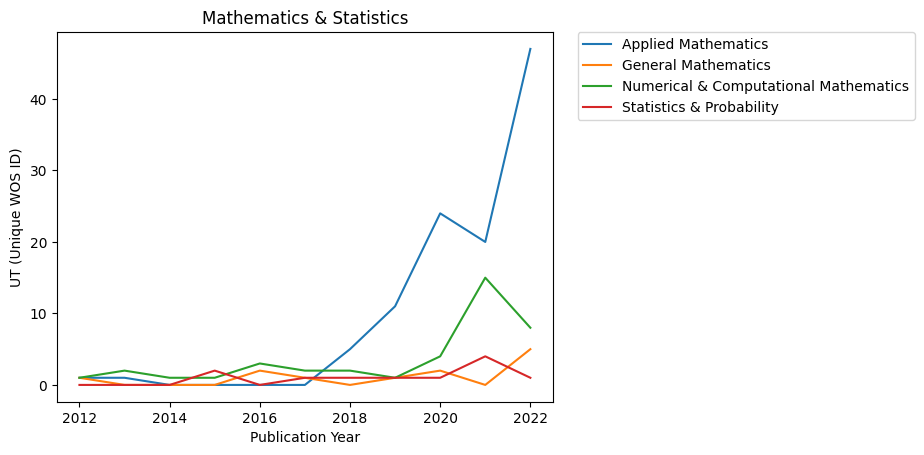

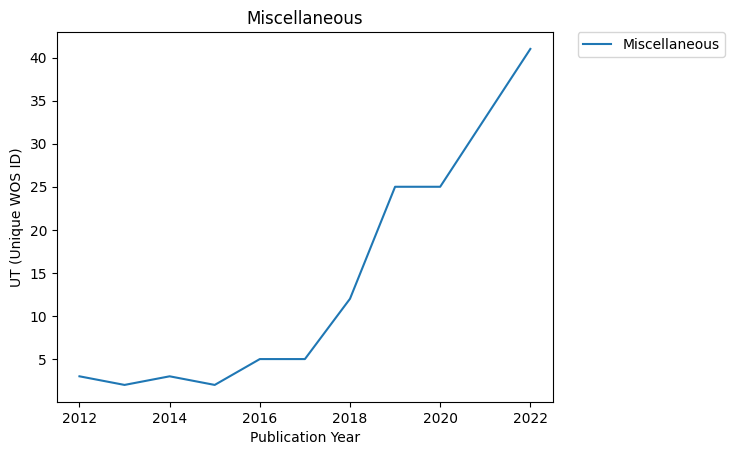

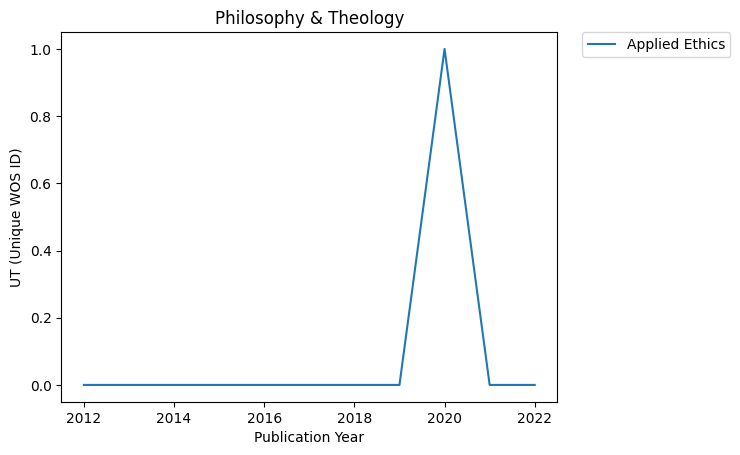

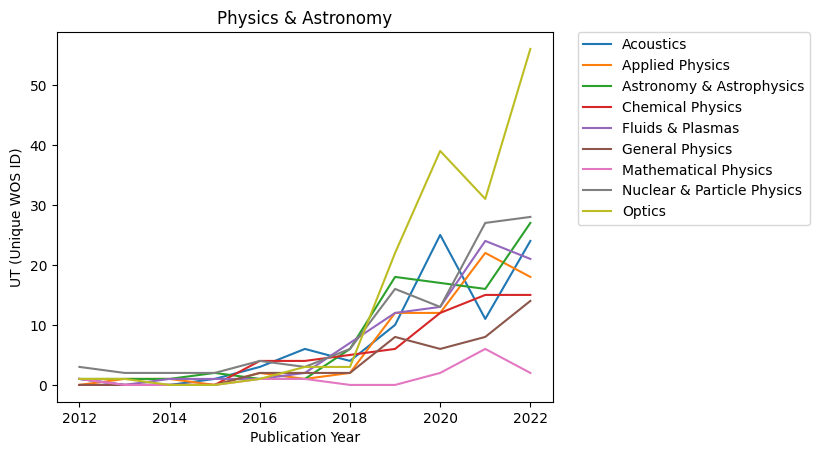

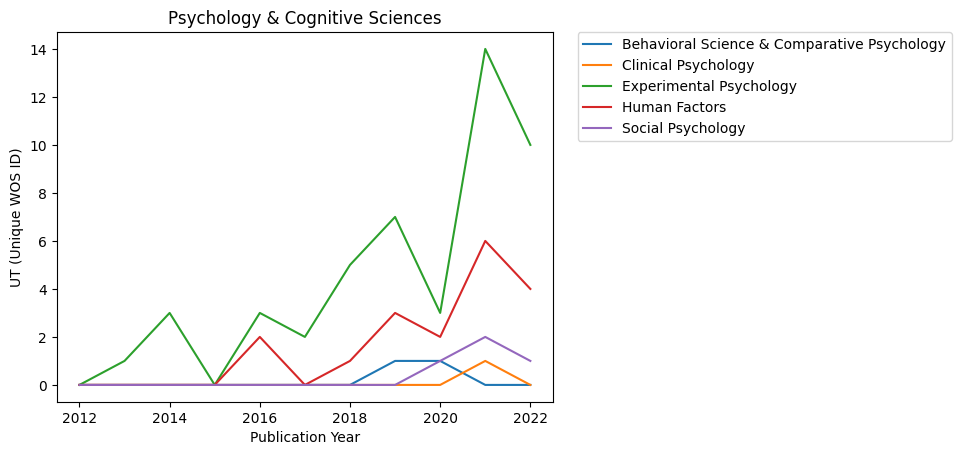

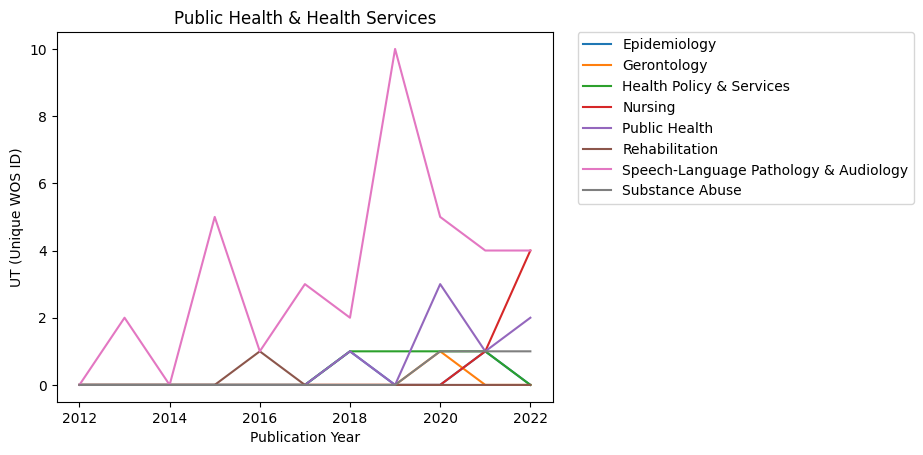

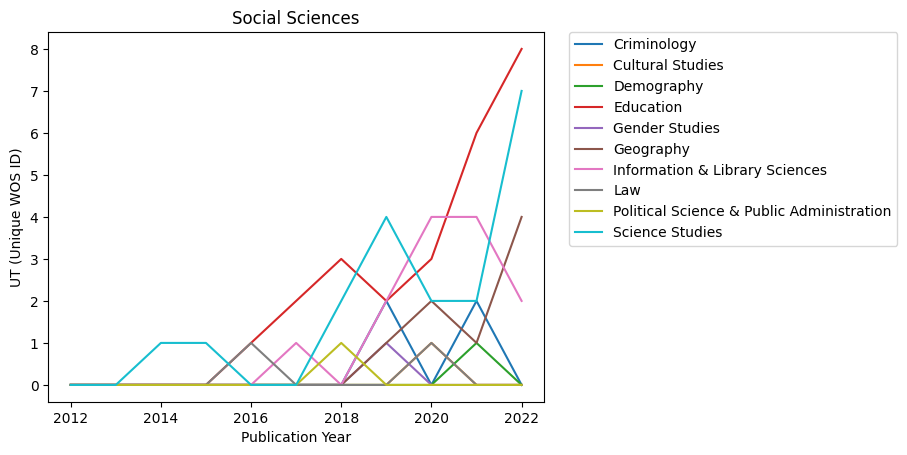

In [69]:
import matplotlib.pyplot as plt
for cat in sorted(data[group[-2]].unique()):
    sub_data = data[data[group[-2]]==cat]
    sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
                                 ,group[-1],fill_value=0)
    g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
    g.set(xticks=list(range(2012,2022+1,2)))
    g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=math.ceil(len(g.legend_.texts)/12))
    g.set_title(cat)
    plt.show()